In [6]:
from scipy.stats import t
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr
from sympy import latex
from sympy import Symbol, latex, diff, sympify, simplify
from sympy.core.numbers import Float, Integer
import numpy as np

class LinModel():
    def __init__(self, dataframe, xlabel='x', ylabel='y', label='', x_units='', y_units='', round_figures=3, rename_x='', x0_form=False):
        self.model_label = label 
        self.x_units = x_units
        self.y_units = y_units
        self.x_var = dataframe[xlabel].copy()
        self.y_var = dataframe[ylabel].copy()
        self.fit()
        self.pars = self.vars_stat_summary[['Parámetro', 'Valor estimado']].set_index('Parámetro')
        
        if x0_form == True:
            b = self.pars.loc['b']
            m = self.pars.loc['m']
            x0 = - b/m 
            sign = '+' if x0['Valor estimado'] < 0 else '-'
            self.pars.loc[xlabel + '0'] = x0
            self.rhs = sympify('m *(' + xlabel + sign + xlabel + '0)')  if rename_x == '' else sympify('m *(' + rename_x + sign + xlabel + '0)')
            rhs = str(self.rhs)
            format_string = "{:." + str(round_figures) + "f}"
            rhs = rhs.replace('m', str(format_string.format(m['Valor estimado'])))
            rhs = rhs.replace(xlabel + '0', str(format_string.format(np.abs(x0['Valor estimado']))))
            self.rhs_subs = sympify(rhs, evaluate=False)
        else: 
            self.rhs = sympify('m *' + xlabel + ' + b') if rename_x == '' else sympify('m *' + rename_x + ' + b')
            self.rhs_subs = self.rhs.subs(self.pars.transpose().round(round_figures).items())
         
        self.lhs = sympify(ylabel + '(' + xlabel + ')')   
        self.expression = str(self.lhs) + ' = ' + str(self.rhs_subs)
        self.ln_expression = latex(self.lhs) + ' = ' + latex(self.rhs_subs)

    def fit(self):
        def stat_error(std, dof):
            t_95 = t.isf(0.025, dof)
            return std*t_95

        coefficients, covariance_matrix = np.polyfit(self.x_var, self.y_var, 1, cov=True)
        self.slope, self.intercept = coefficients
        
        dof = len(self.x_var)-2 # degrees of freedom
        std_slope, std_intercept = np.abs(np.sqrt(np.diag(covariance_matrix)))
        unc_slope, unc_intercept = (stat_error(std_slope, dof), stat_error(std_intercept, dof))
        cov = covariance_matrix[0,1]
        prediction_func = lambda x: self.slope*x + self.intercept
        y_predicted = prediction_func(self.x_var) # f_i = f(x_i)
        ss_res = np.sum((self.y_var - y_predicted)**2)
        ss_tot = np.sum((self.y_var - self.y_var.mean())**2)
        pearson_correlation = cov/std_intercept/std_slope
        coef_of_determination = 1 - ss_res/ss_tot
        # Falta añadir el error experimental, solo se reporta el estadístico!
        
        self.fit_summary = pd.Series(
            data={
                'Pearson correlation r': pearson_correlation,
                'Coefficient of determination R^2': coef_of_determination
            })

        self.vars_stat_summary = pd.DataFrame(
            data={
                'Parámetro' : ['m', 'b'], 
                'Valor estimado':[self.slope, self.intercept],
                'Error estándar': [std_slope, std_intercept], 
                'Incertidumbre':[unc_slope, unc_intercept]
            })
        
    def f_model(self, x):
        return self.slope*x + self.intercept
    
    def plot(self, ax=None, xlabel='', ylabel='', color = (0,0,0.8), legend=True, show_R2=False, data_label=''):
        label = self.model_label
        if type(ax) == type(None):
            _, ax = plt.subplots(1,1)
            
        x = self.x_var
        y = self.y_var

        x_min = x.min()
        x_max = x.max()
        
        x_grid = np.linspace(x_min, x_max, 100)
        y_model = self.f_model(x_grid)
        
        if xlabel == '':
            xlabel += x.name
        if ylabel == '':
            ylabel += y.name
        #curve_label = '$' + str(ylabel) + ' = ' +str(self.rhs_subs) + '$' if show_expression is True else ''
        curve_label = '$' + self.ln_expression + '$' if show_R2 is False else '$' + self.ln_expression + '; R^2 = ' + str(self.fit_summary['Coefficient of determination R^2'].round(2)) +'$'
        
        if self.x_units != '':
            xlabel +=  ' (' + self.x_units + ')'
        if self.y_units != '':
            ylabel += ' (' + self.y_units + ')'
                
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        ax.errorbar(x=x, y=y, marker = '.', ls='', ms='5', color = color, label=data_label)
        ax.plot(x_grid, y_model, color=(*color, 0.3), ls='-', label=curve_label)
        if legend is True:
            ax.legend()

In [11]:
import pandas as pd

dis1 = pd.read_csv('datos/dis_1.csv')
dis2 = pd.read_csv('datos/dis_2.csv')
ebull = pd.read_csv('datos/ebull.csv')

R_vs_T = pd.read_csv('datos/R_vs_T.csv')
R_vs_T['log(R/R0)'] = (R_vs_T['R']/R_vs_T.R.min()).apply(np.log)
R_vs_T_model = LinModel(R_vs_T, xlabel='log(R/R0)', ylabel='T', y_units='°C', round_figures=5)
T = lambda R: R_vs_T_model.f_model(np.log(R/R_vs_T.R.min()))
ebull['T'] = ebull['R'].apply(lambda R: R*1e3).apply(T) 
ebull

,R,n,T
0,8.46,0,78.270633
1,8.42,2,78.372062
2,8.30,4,78.679264
3,8.25,6,78.808578
4,8.17,8,79.017119
5,8.08,10,79.254183


In [9]:
dis1_model = LinModel(dis1, xlabel='n', ylabel='T', y_units='°C', x_units='g', label='dis1', x0_form=True)
dis2_model = LinModel(dis2, xlabel='n', ylabel='T', y_units='°C', x_units='g', label='dis1', x0_form=True)
ebull_model = LinModel(ebull, xlabel='n', ylabel='T', y_units='°C', x_units='g', label='dis1', x0_form=True)

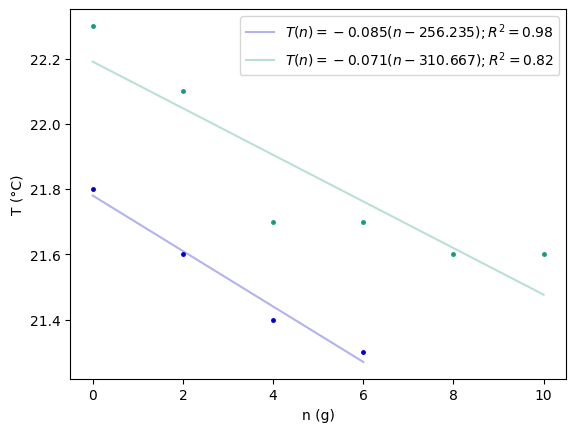

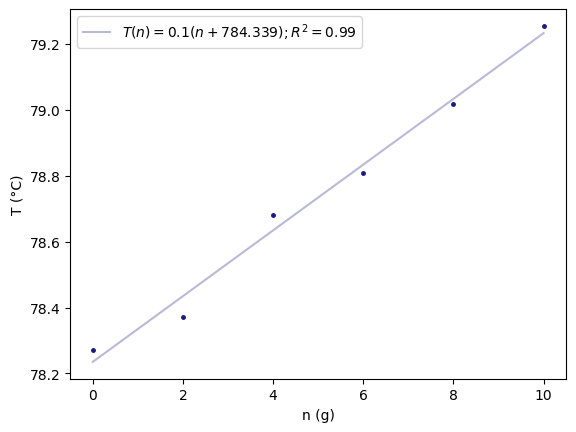

In [13]:
fig, ax = plt.subplots(1,1)
dis1_model.plot(show_R2=True, ax=ax)
dis2_model.plot(show_R2=True, ax=ax, color=(0.1,0.6,0.5))
ebull_model.plot(show_R2=True, color=(0.1,0.1,0.5))